In [521]:
import matplotlib.pyplot as plt
import numpy as np
import cv2
import tensorflow as tf
from sklearn.metrics import f1_score 
from tensorflow.keras import optimizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.gridspec as gridspec
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import Dense, Flatten, MaxPooling2D, Dropout, Conv2D, BatchNormalization
import tensorflow.keras.backend as K

In [522]:
plate_cascade = cv2.CascadeClassifier('Dataset/indian_license_plate.xml')

In [523]:
def detect_plate(img, text=''):
    plate_img = img.copy()
    roi = img.copy()
    plate_rect = plate_cascade.detectMultiScale(plate_img, scaleFactor = 1.2, minNeighbors = 7)
    for (x,y,w,h) in plate_rect:
        roi_ = roi[y:y+h, x:x+w, :] 
        plate = roi[y:y+h, x:x+w, :]
        cv2.rectangle(plate_img, (x+2,y), (x+w-3, y+h-5), (51,181,155), 3) 
    if text!='':
        plate_img = cv2.putText(plate_img, text, (x-w//2,y-h//2), 
                                cv2.FONT_HERSHEY_COMPLEX_SMALL , 0.5, (51,181,155), 1, cv2.LINE_AA)
        
    return plate_img, plate

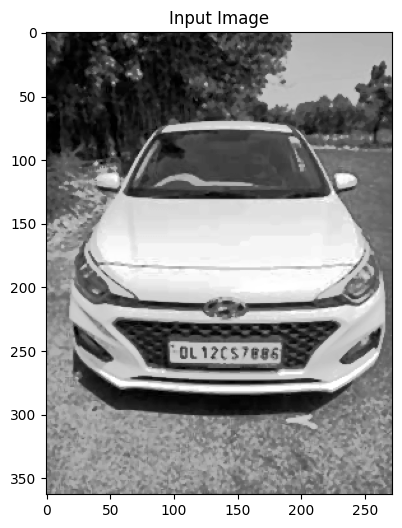

In [524]:
def display(img_, title):
    img = cv2.cvtColor(img_, cv2.COLOR_BGR2RGB)
    img = cv2.medianBlur(img, 3)
    gray_img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    img = cv2.equalizeHist(gray_img)

    fig = plt.figure(figsize=(10,6))
    ax = plt.subplot(111)
    ax.imshow(img, cmap='gray')
    ax.set_title(title)
    plt.show()

InputPic = cv2.imread('Dataset/cars/DL/DL21.jpg')
display(InputPic, 'Input Image')

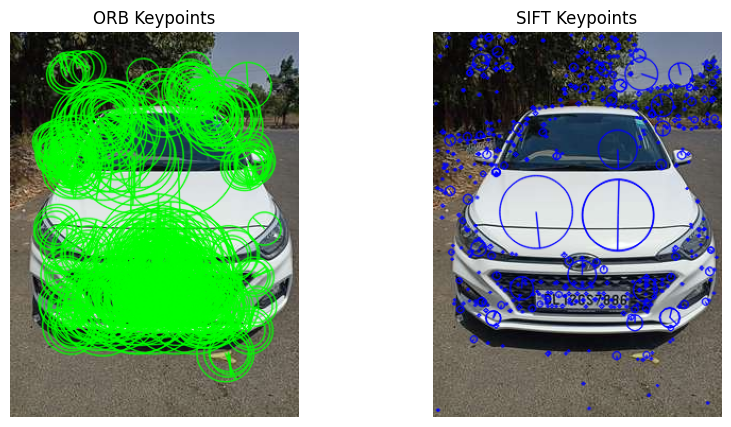

SIFT:  571
ORB: 456


In [525]:
orb = cv2.ORB_create()
keypoints_orb = orb.detect(InputPic, None)
orb_res = InputPic.copy()
keypoints_orb, descriptors_orb = orb.detectAndCompute(InputPic, None)
cv2.drawKeypoints(InputPic, keypoints_orb, orb_res, color=(0, 255, 0), flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

sift = cv2.SIFT_create()
keypoints_sift, descriptors_sift = sift.detectAndCompute(InputPic, None)
descriptors_sift = np.float32(descriptors_sift)
sift_res = InputPic.copy()
cv2.drawKeypoints(sift_res, keypoints_sift, sift_res, color=(255, 0, 0), flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.title('ORB Keypoints')
plt.imshow(cv2.cvtColor(orb_res, cv2.COLOR_BGR2RGB))
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title('SIFT Keypoints')
plt.imshow(cv2.cvtColor(sift_res, cv2.COLOR_BGR2RGB))
plt.axis('off')

plt.show()
print('SIFT: ', len(keypoints_sift))
print('ORB:',len(keypoints_orb))

In [526]:
output_img, plate = detect_plate(InputPic)

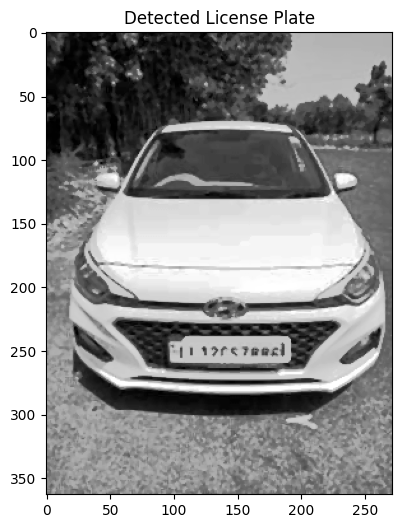

In [527]:
display(output_img, 'Detected License Plate')

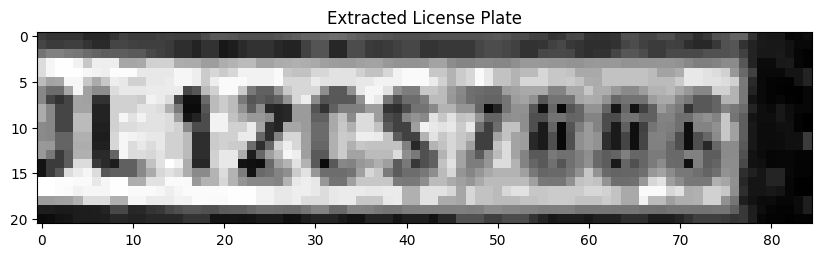

In [528]:
display(plate, 'Extracted License Plate')

In [529]:
def find_contours(dimensions, img) :

    cntrs, _ = cv2.findContours(img.copy(), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

    lower_width = dimensions[0]
    upper_width = dimensions[1]
    lower_height = dimensions[2]
    upper_height = dimensions[3]
    cntrs = sorted(cntrs, key=cv2.contourArea, reverse=True)[:15]
    
    ii = cv2.imread('contour.jpg')
    
    x_cntr_list = []
    target_contours = []
    img_res = []
    for cntr in cntrs :
        intX, intY, intWidth, intHeight = cv2.boundingRect(cntr)
        
        if intWidth > lower_width and intWidth < upper_width and intHeight > lower_height and intHeight < upper_height :
            x_cntr_list.append(intX) 

            char_copy = np.zeros((44,24))
            char = img[intY:intY+intHeight, intX:intX+intWidth]
            char = cv2.resize(char, (20, 40))
            
            cv2.rectangle(ii, (intX,intY), (intWidth+intX, intY+intHeight), (50,21,200), 2)
            plt.imshow(ii, cmap='gray')

            char = cv2.subtract(255, char)

            char_copy[2:42, 2:22] = char
            char_copy[0:2, :] = 0
            char_copy[:, 0:2] = 0
            char_copy[42:44, :] = 0
            char_copy[:, 22:24] = 0

            img_res.append(char_copy) 
            
            
    plt.show()
    indices = sorted(range(len(x_cntr_list)), key=lambda k: x_cntr_list[k])
    img_res_copy = []
    for idx in indices:
        img_res_copy.append(img_res[idx])
    img_res = np.array(img_res_copy)

    return img_res

In [530]:
def segment_characters(image) :

    img_lp = cv2.resize(image, (333, 75))
    img_gray_lp = cv2.cvtColor(img_lp, cv2.COLOR_BGR2GRAY)
    _, img_binary_lp = cv2.threshold(img_gray_lp, 200, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)
    img_binary_lp = cv2.erode(img_binary_lp, (3,3))
    img_binary_lp = cv2.dilate(img_binary_lp, (3,3))

    LP_WIDTH = img_binary_lp.shape[0]
    LP_HEIGHT = img_binary_lp.shape[1]

    img_binary_lp[0:3,:] = 255
    img_binary_lp[:,0:3] = 255
    img_binary_lp[72:75,:] = 255
    img_binary_lp[:,330:333] = 255
    dimensions = [LP_WIDTH/6,
                       LP_WIDTH/2,
                       LP_HEIGHT/10,
                       2*LP_HEIGHT/3]
    plt.imshow(img_binary_lp, cmap='gray')
    plt.show()
    cv2.imwrite('contour.jpg',img_binary_lp)

    char_list = find_contours(dimensions, img_binary_lp)

    return char_list

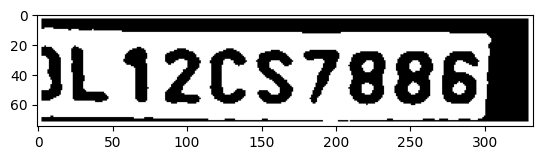

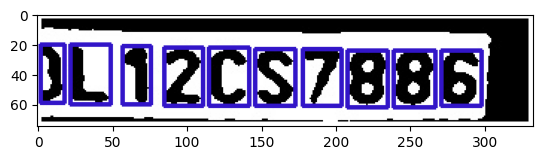

In [531]:
char = segment_characters(plate)

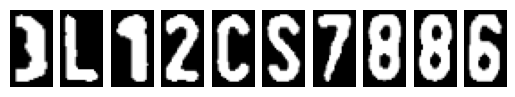

In [532]:
for i in range(len(char)):
    plt.subplot(1, len(char), i+1)
    plt.imshow(char[i], cmap='gray')
    plt.axis('off')

In [533]:
def load_images_from_dataset(dataset_path):
    images = []     
    labels = []
    for class_name in os.listdir(dataset_path):
        class_folder = os.path.join(dataset_path, class_name)

        # Pastikan itu adalah folder, bukan file
        if os.path.isdir(class_folder):
            # Iterasi setiap file gambar dalam folder kelas
            for img_file in os.listdir(class_folder):
                img_path = os.path.join(class_folder, img_file)
                
                # Baca gambar menggunakan OpenCV
                img = cv2.imread(img_path)
                
                # Pastikan gambar terbaca dengan baik
                if img is not None:
                    images.append(img)
                    labels.append(class_name)
                else:
                    print(f"Warning: Gambar {img_path} gagal dibaca!")
    
    return images, labels

dataset_path = 'Dataset/data/data/train'
images, labels = load_images_from_dataset(dataset_path)


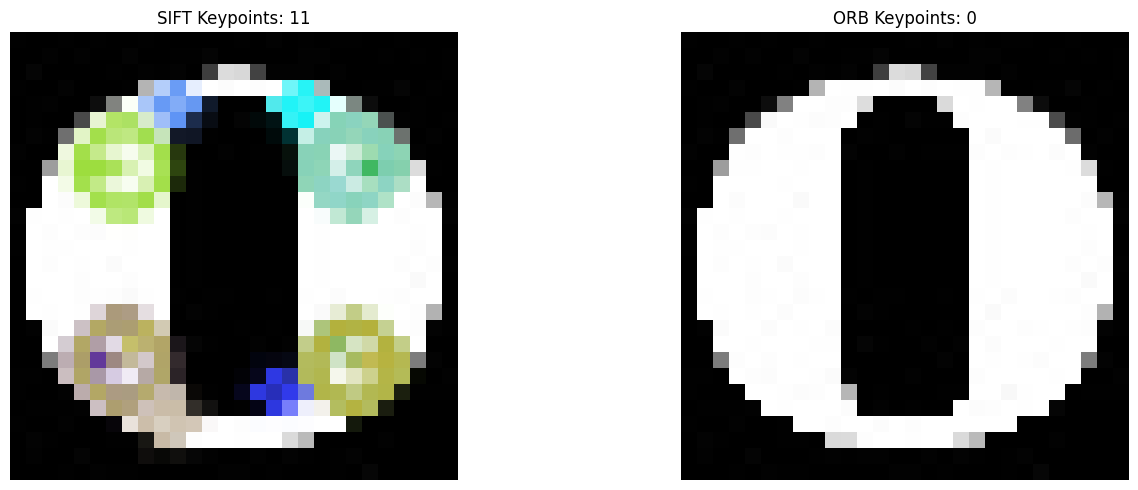

In [534]:
import cv2
import matplotlib.pyplot as plt

if images:
    selected_image = images[0]  
    selected_label = labels[0]  

    grayscale_image = cv2.cvtColor(selected_image, cv2.COLOR_BGR2GRAY)
    # grayscale_image = cv2.resize(grayscale_image,(500,500))
    img = cv2.medianBlur(grayscale_image, 3)
    img = cv2.equalizeHist(img)

    sift = cv2.SIFT_create()
    orb = cv2.ORB_create() 

    keypoints_sift, descriptors_sift = sift.detectAndCompute(grayscale_image, None)
    keypoints_orb, descriptors_orb = orb.detectAndCompute(grayscale_image, None)

    img_sift = cv2.drawKeypoints(selected_image, keypoints_sift, None, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
    img_orb = cv2.drawKeypoints(selected_image, keypoints_orb, None, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

    fig, axs = plt.subplots(1, 2, figsize=(15, 5))

    axs[0].imshow(cv2.cvtColor(img_sift, cv2.COLOR_BGR2RGB))
    axs[0].set_title(f'SIFT Keypoints: {len(keypoints_sift)}')
    axs[0].axis('off')

    axs[1].imshow(cv2.cvtColor(img_orb, cv2.COLOR_BGR2RGB))
    axs[1].set_title(f'ORB Keypoints: {len(keypoints_orb)}')
    axs[1].axis('off')
    plt.tight_layout()
    plt.show()



In [535]:
orb = cv2.ORB_create()

best_matches = 0
best_matches_data = None

for index, (img, label) in enumerate(zip(images, labels)):
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (500, 500))
    grayscale_data = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    grayscale_data = cv2.medianBlur(grayscale_data, 3)
    grayscale_data = cv2.equalizeHist(grayscale_data)

    img_keypoint, img_descriptor = orb.detectAndCompute(grayscale_data, None)

    bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
    matches = bf.match(descriptors_orb, img_descriptor)

    matches = sorted(matches, key=lambda x: x.distance)
    current_matches = len(matches)

    if current_matches > best_matches:
        best_matches = current_matches
        best_matches_data = {
            'image_data': img,
            'keypoint': img_keypoint,
            'descriptor': img_descriptor,
            'match': matches
        }

In [536]:
best_matches = 0
best_matches_data = None

for index, (img, label) in enumerate(zip(images, labels)):
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (600,600))
    grayscale_data = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    grayscale_data = cv2.medianBlur(grayscale_data, 3)
    grayscale_data = cv2.equalizeHist(grayscale_data)

    img_keypoint, img_descriptor = sift.detectAndCompute(grayscale_data, None)

    img_descriptor = np.float32(img_descriptor)

    flann = cv2.FlannBasedMatcher(dict(algorithm=1, trees=20), dict(checks=200))
    matches = flann.knnMatch(descriptors_sift, img_descriptor, k=2)
    matchesmask = [[0, 0] for _ in range(0, len(matches))]

    current_matches = 0

    for i, (fm, sm) in enumerate(matches):
        if fm.distance < 0.6 * sm.distance:
            matchesmask[i] = [1,0]
            current_matches += 1

    if current_matches > best_matches:
        best_matches = current_matches
        best_matches_data = {
            'image_data' : img,
            'keypoint': img_keypoint,
            'descriptor': img_descriptor,
            'match' : matches,
            'matchesmask' : matchesmask
        }

In [537]:
if best_matches_data is not None:
    matched_image_orb = best_matches_data['image_data']
    matched_image_keypoints_orb = best_matches_data['keypoint']
    matches_orb = best_matches_data['match']
    keypoints_input, descriptors_input = orb.detectAndCompute(InputPic, None)
    if not keypoints_input:
        print("No ORB keypoints detected in input image.")

    result_image_orb = cv2.drawMatches(
    InputPic, keypoints_input,  # Perbaikan disini
    matched_image_orb, matched_image_keypoints_orb, 
    matches_orb, None, 
    flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS
    )


    plt.figure(figsize=(10, 5))
    plt.title("Best Matches using ORB")
    plt.imshow(cv2.cvtColor(result_image_orb, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.show()
else:
    print("There's no any match found!.")

if best_matches_data is not None:
    matched_image_sift = best_matches_data['image_data']
    matched_image_keypoints_sift = best_matches_data['keypoint']
    matches_sift = best_matches_data['match']
    matchesmask = best_matches_data['matchesmask']

    good_matches = [m for i, (m, n) in enumerate(matches_sift) if matchesmask[i][0] == 1]
    result_image_sift = cv2.drawMatches(InputPic, None, matched_image_sift, matched_image_keypoints_sift, good_matches, None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

    plt.figure(figsize=(10, 5))
    plt.title("Best Matches using SIFT")
    plt.imshow(cv2.cvtColor(result_image_sift, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.show()
else:
    print("There's no any match found!")

error: OpenCV(4.10.0) :-1: error: (-5:Bad argument) in function 'drawMatches'
> Overload resolution failed:
>  - Can't parse 'matches1to2'. Sequence item with index 0 has a wrong type
>  - Can't parse 'matches1to2'. Sequence item with index 0 has a wrong type
>  - drawMatches() missing required argument 'matchesThickness' (pos 7)
>  - drawMatches() missing required argument 'matchesThickness' (pos 7)
